# Produccion eléctrica en base a la metereología

La idea principal del trabajo es ser capaces de predecir como va a afectar a la produccion eléctrica de energias renovables y no renovables las precipitaciones, el viento y las horas de sol.
Como las horas de sol y el viento son fenomenos cuya causa efecto en principio es prácticamente inmediato, también vamos a centrarnos en la produccion de energia hidroelectrica para poder medir cuanto tiempo tarda en afectar a este tipo de energía las precipitaciones..

En base a esto tenemos varias cuestiones que queremos despejar:
- Que relación hay entre precipitaciones y el aumento de la generación de energia eléctrica hidráulica.
- Que relación hay entre horas de sol, temperatura y el aumento de la generación de energia eléctrica sólar.
- Que relación hay entre viento y el aumento de la generación de energia eléctrica eólica, esta relación esta condicionada por la temperatura, percipitaciones o horas de sol.
- Cuantos días tarda en aumentar la generación eléctrica de fuentes de energía renovables en función de los fenomenos metereológicos.
- Dados una prediccion meteorologica que valores de generación eléctrica tendremos para una fecha determinada.



Como premisas partimos de :
- Vamos a considerar solo el poll de energia que proporciona Red Electrica de España (REE)
- Vamos a considerar que las empresas no trabajan bajo mala praxis y que intentan optimizar el uso de energias renovables.
- Debido a la falta de datos a nivel diario de REE por provincia o comunidades autonomas, voy a centrar el analisis a nivel de sistema eléctrico (Peninsula, Baleares, Canarias ,Ceuta y Melilla).

Como origenes de datos para el estudio vamos a utilizar los datos proporcionados por:
- Información de REE (https://www.ree.es/es/apidatos) obtenida mediante su API.
- Datos proporcionados por aemet(https://opendata.aemet.es/centrodedescargas/inicio), vamos a utilizar la libreria  aemet desarrollada por Pablo Moreno (https://pypi.org/project/python-aemet/).

Requisitos para la ejecución del notebook:

Como requisitos para la ejecución del proyecto es necesario la instalación de la libreria python Aemet(pip install python-aemet) e instalar la libreria request.

Además las versiones de cada libreria utilizada en este proyecto son:

El modelo ha utilizar al tratarse de una prediccion númerica y no de obtener una etiqueta, sera una regresión.
Para poder llevar a cabo esa regresion se han pasado los valores de fechas a númericos, y se ha creado una columna por cada tipo de energia, creando varias variables objetivo.



In [132]:
from aemet import Aemet,Estacion
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import json
import requests
import time

# Leemos la clave de la API de AEMET desde un fichero ubicado en el directorio ../API que este notebook


with open('../API/API_KEY_AEMET','r') as file:
    API_KEY_AE=file.read()

    

###  Lectura datos AEMET

Para la lectura de datos metereólogicos, vamos a utilizar la libreria aemet, de la que utilizaremos los metodos de las clases Aemet y Estacion para obtener los datos a nivel diario de cada estación meterologica para un rago de fechas, de las provincias que nos interesan para el estudio.

In [133]:
# Obtenemos el json de estaciones de mediciones de aemet 
info_estaciones=Estacion.get_estaciones(API_KEY_AE)

# Creamos un objeto Aemet para usar los metodos de la libreria aemet
aemet=Aemet(API_KEY_AE)

In [134]:
from tqdm import tqdm_notebook as tqdm

# Definimos funciones que vamos a utilizar para leer los datos de AEMET
def estaciones_prov (prov,lista_estaciones):
    '''Dada una lista de provincias y un json de estaciones de aemet. 
    Obtiene una lista de los ID de las estaciones de esa provincia.'''
    lista_id=[]
    prov=list(map(str.upper, prov))
    for estacion in tqdm(lista_estaciones):
        if estacion['provincia'] in prov:
            lista_id.append(estacion['indicativo'])
    return lista_id



def lectura_diaria_lista(date_ini,date_end,lista_estaciones):
    '''Dado una lista de id de estaciones de aemet, y fechas de inicio y fin:
    Obtenemos los datos climatologicos entre las dos fechas para todas las estaciones de manera diaria
    Si la fecha de inicio es anterior a 2016, se cambia a 2016-01-01, para evitar errores.
    '''
    valores_diarios=[]
    if date_ini[0:4]<'2016-01':
        date_ini="2016-01-01T00:00:00UTC"
    if date_ini>date_end:
        print('Valores no válidos, fecha de inicio mayor que la fecha de fin')
        return valores_diarios;
    for element in tqdm(lista_estaciones):
        try:
            valores_estacion=aemet.get_valores_climatologicos_diarios(date_ini,date_end,element)
            if type(valores_estacion)!=dict:
                valores_diarios.extend(valores_estacion)
        except:
            time.sleep(56) # para evitar errores por nº de lecturas.
            try:
                valores_estacion=aemet.get_valores_climatologicos_diarios(date_ini,date_end,element)
                if type(valores_estacion)!=dict:
                    valores_diarios.extend(valores_estacion)
            except:
                print('Valor no encontrado')
                
    return valores_diarios;

In [136]:
# Parametros para lectura de datos de AEMET

provincias=['Ceuta','Melilla','Illes Balears','Las Palmas','Sta. Cruz de Tenerife']

date_ini="2016-01-01T00:00:00UTC"
date_end="2017-12-31T00:00:00UTC"

id_estaciones=estaciones_prov(provincias,info_estaciones)

# Pasamos los datos ha dataframes para su procesado y limpieza
estaciones=pd.DataFrame(info_estaciones)
df_weather1=pd.DataFrame(lectura_diaria_lista(date_ini,date_end,id_estaciones),dtype=str)

In [138]:
df_weather=df_weather.append(df_weather1)

### Limpieza datos AEMET

In [139]:
# Creo una funcion que pase los indicadores a float y rellene los valores vacios por la temperatura media de las estaciones de esa provincia
def rellena_nulos_provincia(df,cols):
    # Defino un DataFrame vacio para acumular el resultado
    df_all=pd.DataFrame()
    
    # Hago un bucle para cada provincia del DataFrame de entrada
    for prov in df['provincia'].unique():
        df_prov=df[df['provincia']==prov].copy()
        
        #Para cada elemento de las columnas que nos interesan reemplazo , por ., paso a numerico y relleno los nulos por la media de la provincia
        for element in cols:
            df_prov[element]=df_prov[element].str.replace(',', '.')
            df_prov[element]=pd.to_numeric(df_prov[element],errors='coerce')
            df_prov[element].fillna(df_prov[element].mean(skipna=True),inplace=True)
        df_all=df_all.append(df_prov)
    return df_all

In [140]:
# Elimino las columnas que no me interesan
df_weather.drop(columns=['altitud','horaPresMax','horaPresMin','horaracha','dir','horatmin','horatmax','racha'],inplace=True)

# Limpio de nulos la muestra
df_weather=rellena_nulos_provincia(df_weather,df_weather.columns[5:])


In [141]:
# Dejo los datos agrupados por provincia y fecha
weather_grouped=df_weather.groupby(['fecha','provincia'],as_index=False)
df_weather_prov=weather_grouped.mean(['tmed','prec','tmin','tmax','velmedia','sol','presMax','presMin'])

## Lectura de los datos de REE

Para la lectura de los datos de REE voy a utilizar la libreria python requests para a traves de su API, obtener la generación de electricidad en , para cada tipo de energia Electrica.

Una vez leidos los datos de la API, guardo los datos en formato json en un fichero. para no tener que repetir las consultas y poder trabajar sin conexion.

La estrutura de los datos leidos de REE es la siguiente:


Por lo que vamos a almacenar 2 ficheros:
    - Renovables
    - No Renovables



In [142]:
# Leemos las regiones de ree obtenidas desde (https://www.ree.es/es/apidatos) desde un fichero ubicado en la misma ruta que este notebook
region_ree=pd.read_csv('../Data/REGION_REE',header=0,index_col='Region')

# Me quedo solo con los distintos sistemas electricos existentes
region_system=region_ree[region_ree['geo_limit']!='ccaa']

region_system

,geo_limit,geo_id
Region,,
peninsular,peninsular,8741
canarias,canarias,8742
baleares,baleares,8743
ceuta,ceuta,8744
melilla,melilla,8745


In [143]:
# Obtenemos los datos de REE a traves de su API. 

def lectura_ree_electric_system(d_inicio,d_fin,geo_id):
    '''Dada una fecha'''
    # meter esto en una funcion con su try-exception    
    # Dividir la lectura por años
    
    geo_limit=region_system[region_system['geo_id']==geo_id]['geo_limit']
    
    parametros={'start_date':date_ini,
            'end_date':date_end,
            'time_trunc':'day',
            'geo_trunc':'electric_system',
            'geo_limit':geo_limit[0],
            'geo_ids':geo_id}
    
    URL_GEN='https://apidatos.ree.es/es/datos/generacion/estructura-generacion'

    ree_gen=requests.get(URL_GEN,params=parametros)
    
    df_ree=pd.DataFrame()
    for i in range(20):
        try:
            df=pd.json_normalize(ree_gen.json()['included'][i]['attributes'],meta=['title','type'],record_path=['values'])
            df['system']=geo_limit[0]
            df_ree=df_ree.append(df)
        except:
            pass #Cuando no hay datos para mas tecnologías
    df_ree.reset_index(inplace=True,drop=True)
    
    return df_ree

In [144]:
df_ree_system=pd.DataFrame()

In [149]:

date_ini="2020-01-01T00:00:00UTC"
date_end="2020-12-31T00:00:00UTC"

for electric_system in tqdm(region_system['geo_id']):
    df_ree_system=df_ree_system.append(lectura_ree_electric_system(date_ini,date_end,electric_system))
df_ree_system 

,value,percentage,datetime,title,type,system
0,29281.000,0.054518,2016-01-01T00:00:00.000+01:00,Hidráulica,Renovable,peninsular
1,35544.881,0.057414,2016-01-02T00:00:00.000+01:00,Hidráulica,Renovable,peninsular
2,35910.705,0.054150,2016-01-03T00:00:00.000+01:00,Hidráulica,Renovable,peninsular
3,65268.886,0.097287,2016-01-04T00:00:00.000+01:00,Hidráulica,Renovable,peninsular
4,79718.832,0.111964,2016-01-05T00:00:00.000+01:00,Hidráulica,Renovable,peninsular
...,...,...,...,...,...,...
1757,544.484,1.000000,2020-12-27T00:00:00.000+01:00,Generación total,Generación total,melilla
1758,568.881,1.000000,2020-12-28T00:00:00.000+01:00,Generación total,Generación total,melilla
1759,585.858,1.000000,2020-12-29T00:00:00.000+01:00,Generación total,Generación total,melilla
1760,589.612,1.000000,2020-12-30T00:00:00.000+01:00,Generación total,Generación total,melilla


# Limpieza de datos de REE

In [150]:
# Renombro los campos
df_ree_system.rename(columns={'value':'Generacion_Mwh','title':'Tecnologia','type':'Renov_norenov'},inplace=True)

# Elimino la columna percentage por ser una columna generada de Generacion_Mwh.
df_ree_system.drop('percentage',axis=1,inplace=True)

# Cambio los valores nulos de Generacion en Mwh por 0
df_ree_system['Generacion_Mwh'].fillna(0)

# Elimino las filas para las cuales la fecha es nula y paso la fecha a formato corto.
df_ree_system['fecha']=df_ree_system['datetime'].str[:10]
df_ree_system=df_ree_system[~df_ree_system['fecha'].isna()]
df_ree_system.drop('datetime',axis=1,inplace=True)
df_ree_system

,Generacion_Mwh,Tecnologia,Renov_norenov,system,fecha
0,29281.000,Hidráulica,Renovable,peninsular,2016-01-01
1,35544.881,Hidráulica,Renovable,peninsular,2016-01-02
2,35910.705,Hidráulica,Renovable,peninsular,2016-01-03
3,65268.886,Hidráulica,Renovable,peninsular,2016-01-04
4,79718.832,Hidráulica,Renovable,peninsular,2016-01-05
...,...,...,...,...,...
1757,544.484,Generación total,Generación total,melilla,2020-12-27
1758,568.881,Generación total,Generación total,melilla,2020-12-28
1759,585.858,Generación total,Generación total,melilla,2020-12-29
1760,589.612,Generación total,Generación total,melilla,2020-12-30


# Repositorio de información

Para evitar tener que leer todos los datos en cada ejecucion, guardamos los datos de 2016 a 2020 en formato csv desde los DataFrame de REE y AEMET

In [151]:
#df_ree_system.to_csv('../Data/ree_system.csv')

In [152]:
#df_weather_prov.to_csv('../Data/wheater.csv')

# Lectura desde el Repositorio

In [153]:
df_ree_system=pd.read_csv('../Data/ree_system.csv',index_col=0)
df_weather=pd.read_csv('../Data/wheater.csv',index_col=0)

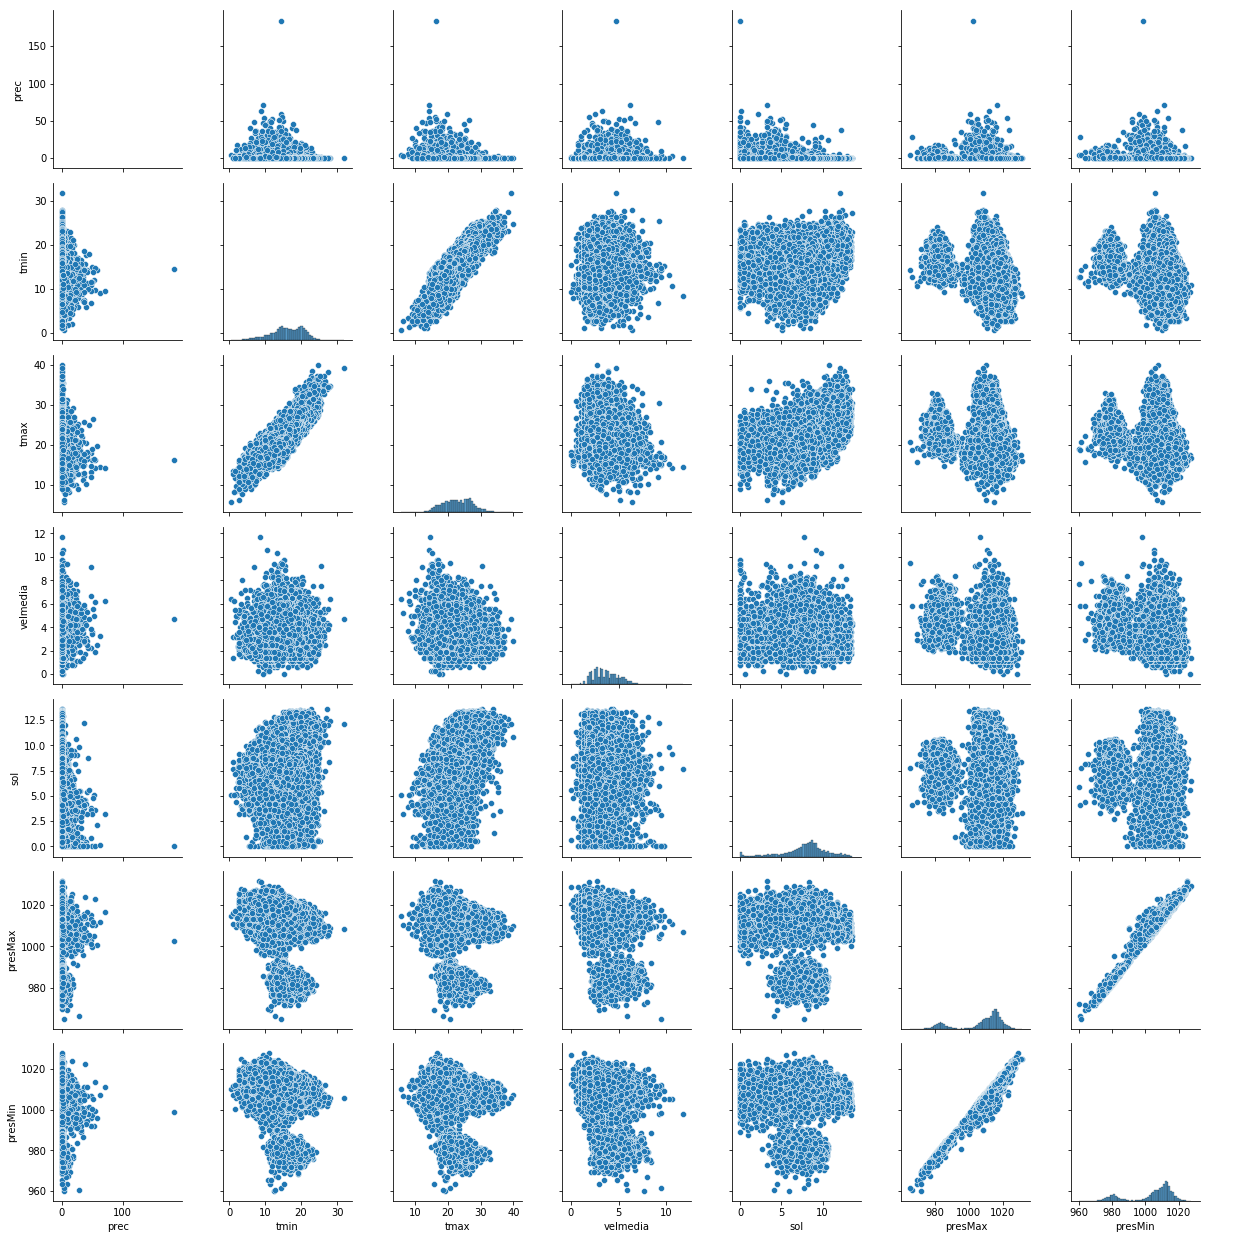

In [154]:
import seaborn as sns

sns.pairplot(df_weather)

# Features 

Para hacer un primer modelo quito generación total

In [155]:
df_ree_system=df_ree_system[~(df_ree_system['Renov_norenov']=='Generación total')]

# Encoder REE

In [157]:
from sklearn.preprocessing import OneHotEncoder


enc=OneHotEncoder(drop='if_binary').fit(df_ree_system[['Tecnologia','Renov_norenov','system']])

df_transform=enc.transform(df_ree_system[['Tecnologia','Renov_norenov','system']])

column_names=enc.get_feature_names(['Tecnologia','Renov_norenov','system'])
df_onehot =  pd.DataFrame(df_transform.todense(), columns= column_names)

###  Tratamiento de fechas

Para pasar las fechas aun formato en que el salto entre el ultimo dia de un mes y el primer dia del siguiente sea continuo, uso los cosenos de los dias y meses. 

Para ello situo los valores de los 31 dias en angulos iguales calulandolos como $Dia(x)=\cos\frac{2\pi}{31}x$

Del mismo modo para los meses situo cada mes en $Mes(x)=\cos\frac{2\pi}{12}x$

In [158]:
df_ree_system['year']=df_ree_system['fecha'].str.slice(0,4)
df_ree_system['day']=df_ree_system['fecha'].str.slice(8,10)
df_ree_system['month']=df_ree_system['fecha'].str.slice(5,7)

In [159]:
df_ree_system['day_t']=np.cos((2*np.pi)/df_ree_system['day'].astype(int))
df_ree_system['month_t']=np.cos(((2*np.pi)/12)*df_ree_system['month'].astype(int))
df_ree_system.drop(['month','day','Tecnologia','Renov_norenov','system'],axis=1,inplace=True)

,Generacion_Mwh,year,day_t,month_t
0,29281.0000,2016,1.000000e+00,0.866025
1,35544.8810,2016,-1.000000e+00,0.866025
2,35910.7050,2016,-5.000000e-01,0.866025
3,65268.8860,2016,6.123234e-17,0.866025
4,79718.8320,2016,3.090170e-01,0.866025
...,...,...,...,...
1391,20.6945,2020,9.730449e-01,1.000000
1392,20.7725,2020,9.749279e-01,1.000000
1393,21.4650,2020,9.766206e-01,1.000000
1394,21.1730,2020,9.781476e-01,1.000000


In [160]:
df_weather['year']=df_weather['fecha'].str.slice(0,4)
df_weather['day']=df_weather['fecha'].str.slice(8,10)
df_weather['month']=df_weather['fecha'].str.slice(5,7)
df_weather['day_t']=np.cos((2*np.pi)/df_weather['day'].astype(int))
df_weather['month_t']=np.cos(((2*np.pi)/12)*df_weather['month'].astype(int))
df_weather=df_weather.drop(['day','month'],axis=1,inplace=True)

# Unir las 3 tablas df_weather, df_ree_system, df_onehot

In [166]:
df_ree_features=df_ree_system.join(df_onehot)

,Generacion_Mwh,year,day_t,month_t,Tecnologia_Carbón,Tecnologia_Ciclo combinado,Tecnologia_Cogeneración,Tecnologia_Eólica,Tecnologia_Fuel + Gas,Tecnologia_Hidroeólica,...,Tecnologia_Solar térmica,Tecnologia_Turbina de gas,Tecnologia_Turbina de vapor,Tecnologia_Turbinación bombeo,Renov_norenov_Renovable,system_baleares,system_canarias,system_ceuta,system_melilla,system_peninsular
0,29281.0000,2016,1.000000,0.866025,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
0,9.1630,2016,1.000000,0.866025,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
0,3032.1870,2016,1.000000,0.866025,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
0,461.3530,2016,1.000000,0.866025,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
0,447.0610,2016,1.000000,0.866025,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4396,1970.1720,2020,0.974928,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4397,186.9455,2016,0.979530,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4397,1906.6040,2020,0.976621,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4398,1346.8765,2020,0.978148,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


,Tecnologia_Carbón,Tecnologia_Ciclo combinado,Tecnologia_Cogeneración,Tecnologia_Eólica,Tecnologia_Fuel + Gas,Tecnologia_Hidroeólica,Tecnologia_Hidráulica,Tecnologia_Motores diésel,Tecnologia_Nuclear,Tecnologia_Otras renovables,...,Tecnologia_Solar térmica,Tecnologia_Turbina de gas,Tecnologia_Turbina de vapor,Tecnologia_Turbinación bombeo,Renov_norenov_Renovable,system_baleares,system_canarias,system_ceuta,system_melilla,system_peninsular
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65541,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
65542,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
65543,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
65544,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


# Modelo

# Evaluacion

Crear tabla de resultados.

# Interfaz y ploteado
